In [1]:
import numpy as np
import torch
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split

import os
import json
from collections import Counter

os.chdir('..')
from configs import path_config, data_config, train_config
from src import visualize_batch, get_dataloader, get_dataset
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Finding the Mean and Standard Deviation of Image Channels

In [2]:
transforms = v2.Compose([
    v2.PILToTensor(),
    v2.Resize((224,224)),
    v2.ToDtype(torch.float32, scale=True),
])

In [3]:
dataset = ImageFolder(root=path_config.dataset_path, transform=transforms)
dataloader = DataLoader(dataset, batch_size=8)

In [4]:
mean = 0
std = 0
n_images = 0

for batch in tqdm(dataloader):
    images, _ = batch
    images = images.view(images.size(0), images.size(1), -1) # [B, C, W*H]
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    n_images += images.size(0)

mean /= n_images
std /= n_images

print(mean)
print(std)

  0%|          | 0/853 [00:00<?, ?it/s]

tensor([0.6053, 0.5874, 0.5538])
tensor([0.2468, 0.2372, 0.2453])


In [6]:
trainset, valset = get_dataset(train=True)
trainloader = get_dataloader(trainset, True)
valloader = get_dataloader(valset, True)

In [10]:
len(trainset), len(trainloader)*8

(5524, 5528)

In [4]:
classes = {'class_to_idx': dataset.class_to_idx, 
           'idx_to_class': dataset.classes}
with open(path_config.classes_file, 'w') as f:
    json.dump(classes, f, indent=4)

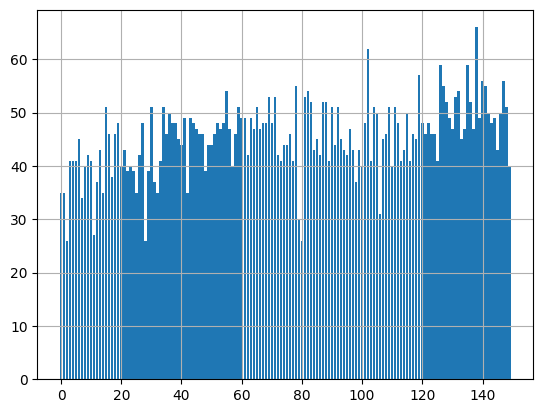

In [5]:
class_dist = Counter(dataset.targets)
x = np.arange(max(dataset.targets)+1)
y = [class_dist[c] for c in x]
plt.bar(x, y)
plt.grid()
plt.show()

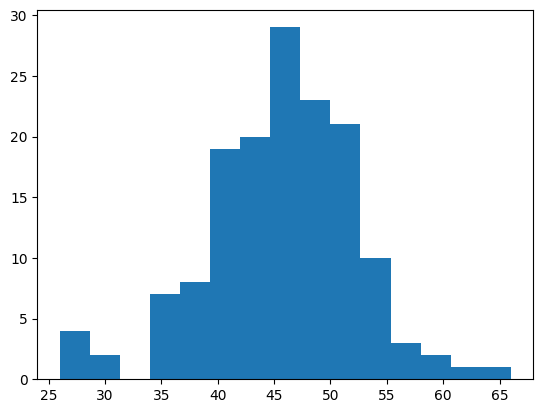

In [6]:
plt.hist(y, bins = 15)
plt.show()

In [9]:
def visualize_batch(images, targets, preds = None):
    images = images.type(torch.DoubleTensor)
    targets = targets.type(torch.ByteTensor)
    if preds is not None:
        preds = preds.type(torch.ByteTensor)
    
    images = images * data_config.std.view(1,-1,1,1) + data_config.mean.view(1,-1,1,1)
    images = images.numpy().transpose((0, 2, 3,1))

    n = images.shape[0]
    
    fig, axes = plt.subplots(nrows=2, ncols=n//2)
    axes = list(axes[0]) + list(axes[1])
    for i in range(n):
        img = to_pil_image(images[i], mode='RGB')
        axes[i].imshow(img)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        if preds is not None:
            axes[i].set_xlabel(
                f"y: {classes['idx_to_class'][targets[i].item()]}\ny_hat: {classes['idx_to_class'][preds[i].item()]}"
            )
        else:
            axes[i].set_xlabel(
                f"y: {classes['idx_to_class'][targets[i].item()]}"
            )
    
    plt.show()
    

AttributeError: "'idx_to_class'"

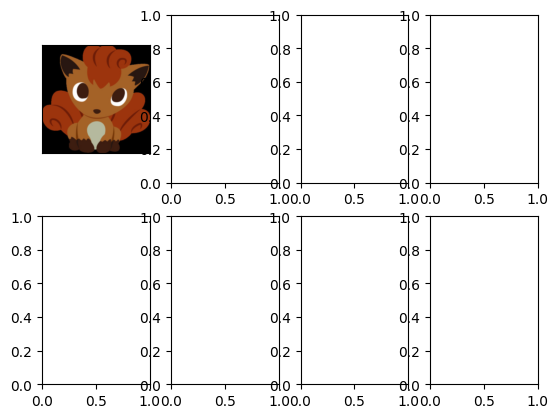

In [8]:
images, labels = next(iter(dataloader))
visualize_batch(images, labels)

In [11]:
train_idx, test_idx = train_test_split(
        np.arange(len(dataset)),
        test_size=0.1,
        random_state=train_config.training.seed,
        shuffle=True,
        stratify=dataset.targets,
    )
len(train_idx), len(test_idx)

(6138, 682)

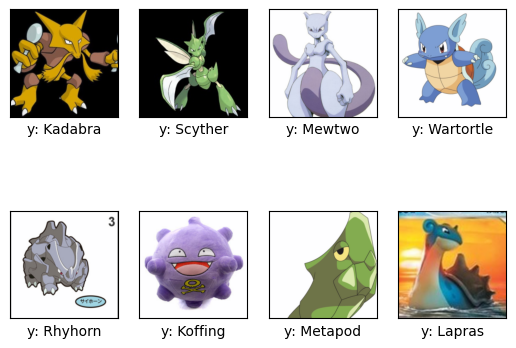

In [12]:
visualize_batch(images, labels)